In [ ]:
!pip install tweepy

import numpy as np
import tweepy
import pickle
import pandas as pd
import csv
import time
from matplotlib import pyplot as plt
import seaborn as sns

## Loading the Polling Data

In [2]:
rcp = pd.read_csv('rcp polling averages.csv')
rcp['Date'] = pd.to_datetime(rcp['Date'])
rcp['Date'] = rcp['Date'].apply(lambda d: d.date())
rcp = rcp.set_index('Date')
rcp['Diff'] = rcp['Biden'] - rcp['Trump']
rcp.head()

,Biden,Trump,Diff
Date,,,
2020-11-03,51.2,44.0,7.2
2020-11-02,51.1,44.2,6.9
2020-11-01,51.1,43.9,7.2
2020-10-31,51.3,43.5,7.8
2020-10-30,51.4,43.5,7.9


## Loading and Preparing the Candidates' Tweet Data

In [3]:
candidate_tweets = pickle.load(open( "My Data/canidate_tweets.p", "rb"))

In [199]:
#Recording the important metrics for tweets: ID, User ID, Time, Text, Retweets, Favorites
tweets = []
for c in candidate_tweets:
    for t in c:
        tweet = [t.id, t.user.name, t.user.followers_count, t.created_at, t.text, t.retweet_count, t.favorite_count]
        if tweet[1] == 'Joe Biden' or tweet[1] == 'Donald J. Trump':
            tweets.append(tweet)

In [200]:
tweets = pd.DataFrame(tweets, columns=['Tweet ID', 'User Name', 'Followers', 'Time', 'Text', 'Retweets', 'Favorites'])
tweets = tweets.set_index('Tweet ID')
#Retweets have a favorite value of 0 so we won't use them
tweets = tweets[tweets['Favorites']!=0]

In [201]:
#Getting rid of all tweets after the election and before 8 weeks before the election
tweets = tweets[tweets['Time'] > pd.to_datetime('20201014', format='%Y%m%d')]
tweets = tweets[tweets['Time'] < pd.to_datetime('20201104', format='%Y%m%d')]

In [202]:
tweets.head()

,User Name,Followers,Time,Text,Retweets,Favorites
Tweet ID,,,,,,
1323770935728607237,Joe Biden,19998870,2020-11-03 23:36:00,As polls begin to close in certain parts of th...,17870,118004
1323761880234553346,Joe Biden,19998870,2020-11-03 23:00:01,"Folks, time is running out to make your voice ...",4076,39275
1323753975221522433,Joe Biden,19998870,2020-11-03 22:28:36,This is our moment to prove that:\n\nLove is m...,25961,192593
1323747783732535300,Joe Biden,19998870,2020-11-03 22:04:00,"Let's win this thing, Pennsylvania! https://t....",15846,205181
1323739479069392904,Joe Biden,19998870,2020-11-03 21:31:00,Who we are. What we stand for. Who we are goin...,6768,57250


In [203]:
tweets_b = tweets[tweets['User Name']=='Joe Biden']
tweets_t = tweets[tweets['User Name']=='Donald J. Trump']

tweets_b = tweets_b.set_index('Time')
tweets_b = tweets_b[['Retweets', 'Favorites', 'Followers']]
tweets_b['Biden Re/Fo'] = tweets_b['Retweets'] / tweets_b['Followers']
tweets_b['Biden Fa/Fo'] = tweets_b['Favorites'] / tweets_b['Followers']

tweets_t = tweets_t.set_index('Time')
tweets_t = tweets_t[['Retweets', 'Favorites', 'Followers']]
tweets_t['Trump Re/Fo'] = tweets_t['Retweets'] / tweets_t['Followers']
tweets_t['Trump Fa/Fo'] = tweets_t['Favorites'] / tweets_t['Followers']

In [204]:
tweets_b = tweets_b[tweets_b.columns.to_list()].resample('D').mean()
tweets_t = tweets_t[tweets_t.columns.to_list()].resample('D').mean()

In [205]:
tweets_b = tweets_b[['Biden Re/Fo', 'Biden Fa/Fo']]
tweets_t = tweets_t[['Trump Re/Fo', 'Trump Fa/Fo']]

In [206]:
print(str(len(tweets))+" Total Tweets")
tweets_b.head()

1181 Total Tweets


,Biden Re/Fo,Biden Fa/Fo
Time,,
2020-10-14,0.000872,0.005623
2020-10-15,0.000599,0.003900
2020-10-16,0.000605,0.003968
2020-10-17,0.000779,0.003792
2020-10-18,0.000589,0.003216


## Loading and Preparing Scraped Tweets

These tweets were scraped looking for "#DonaldTrump", "#Trump", "#JoeBiden", "#Biden". 

In [ ]:
biden = pd.read_csv('Manch Hui Dataset/hashtag_joebiden.csv')

In [13]:
trump = pd.read_csv('Manch Hui Dataset/hashtag_donaldtrump.csv', engine='python')

In [14]:
#Cleaning the data
biden['temp'] = biden['created_at'].apply(lambda x: len(x))
trump['temp'] = trump['created_at'].apply(lambda x: len(x))
biden = biden[biden['temp']==19]
trump = trump[trump['temp']==19]
biden = biden.drop(columns='temp')
trump = trump.drop(columns='temp')

In [15]:
biden['created_at'] = pd.to_datetime(biden['created_at'])
trump['created_at'] = pd.to_datetime(trump['created_at'])

In [16]:
#Getting tweets only in the eight week period
biden = biden[biden['created_at'] > pd.to_datetime('20200908', format='%Y%m%d')]
biden = biden[biden['created_at'] < pd.to_datetime('20201104', format='%Y%m%d')]
trump = trump[trump['created_at'] > pd.to_datetime('20200908', format='%Y%m%d')]
trump = trump[trump['created_at'] < pd.to_datetime('20201104', format='%Y%m%d')]

In [17]:
biden = biden[['created_at', 'tweet_id', 'tweet', 'likes', 'retweet_count', 'user_followers_count']]
biden = biden.set_index('tweet_id')
trump = trump[['created_at', 'tweet_id', 'tweet', 'likes', 'retweet_count', 'user_followers_count']]
trump = trump.set_index('tweet_id')

In [18]:
print(str(len(biden)+len(trump))+" Total Tweets")
biden.head()

884391 Total Tweets


,created_at,tweet,likes,retweet_count,user_followers_count
tweet_id,,,,,
1.316529221557252e+18,2020-10-15 00:00:01,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,1860.0
1.31652929585929e+18,2020-10-15 00:00:18,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...,0.0,0.0,6628.0
1.3165293050069524e+18,2020-10-15 00:00:20,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,0.0,0.0,1536.0
1.3165293080815575e+18,2020-10-15 00:00:21,@chrislongview Watching and setting dvr. Let’s...,0.0,0.0,27.0
1.316529312741253e+18,2020-10-15 00:00:22,#censorship #HunterBiden #Biden #BidenEmails #...,1.0,0.0,390.0


## Performing Sentiment Analysis on Tweets

In [19]:
import nltk.sentiment
from nltk.sentiment import SentimentIntensityAnalyzer

In [20]:
#Importing VADER and recording the compound score for each tweet
vader = SentimentIntensityAnalyzer()
sent = []
for t in biden['tweet']:
    sent.append(vader.polarity_scores(t)['compound'])
biden['Sentiment'] = sent
sent = []
for t in trump['tweet']:
    sent.append(vader.polarity_scores(t)['compound'])
trump['Sentiment'] = sent

In [21]:
biden['likes'] = pd.to_numeric(biden['likes'])
biden['user_followers_count'] = pd.to_numeric(biden['user_followers_count'])
trump['likes'] = pd.to_numeric(trump['likes'])
trump['user_followers_count'] = pd.to_numeric(trump['user_followers_count'])

In [22]:
#Multiplying the sentiment score by the structural features
biden['Biden Agg Favorites'] = biden['likes'] * biden['Sentiment']
biden['Biden Agg Retweets'] = biden['retweet_count'] * biden['Sentiment']
biden['Biden Agg Followers'] = biden['user_followers_count'] * biden['Sentiment']
trump['Trump Agg Favorites'] = trump['likes'] * trump['Sentiment']
trump['Trump Agg Retweets'] = trump['retweet_count'] * trump['Sentiment']
trump['Trump Agg Followers'] = trump['user_followers_count'] * trump['Sentiment']

In [23]:
biden = biden[['created_at', 'Biden Agg Favorites', 'Biden Agg Retweets', 'Biden Agg Followers']]
trump = trump[['created_at', 'Trump Agg Favorites', 'Trump Agg Retweets', 'Trump Agg Followers']]

In [24]:
#Aggregating the features by the day
biden = biden.set_index('created_at')
biden = biden[biden.columns.to_list()].resample('D').mean()
trump = trump.set_index('created_at')
trump = trump[trump.columns.to_list()].resample('D').mean()

In [25]:
biden.head()

,Biden Agg Favorites,Biden Agg Retweets,Biden Agg Followers
created_at,,,
2020-10-15,5.941633,2.489461,266.497554
2020-10-16,12.017065,1.605517,-150.145627
2020-10-17,0.019888,0.000348,-143.544718
2020-10-18,-0.512274,-0.191605,638.397022
2020-10-19,-0.153568,-0.071789,934.004722


## Combining Datasets and EDA

In [221]:
biden_agg = biden.join(tweets_b)
trump_agg = trump.join(tweets_t)

In [222]:
#Before combining the datasets we need to ensure the data is stationary so that we can perform timeseries analysis
from statsmodels.tsa.stattools import adfuller

def adf_test(ds):
    dftest = adfuller(ds, autolag='AIC')
    adf = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','# Lags','# Observations'])
    p = adf['p-value']
    if p <= 0.05:
        return "Series is Stationary"
    else:
        return "Series is Non-Stationary"

for i in biden_agg.columns:
    print(i, " --> ", adf_test(biden_agg[i]))
    
for i in trump_agg.columns:
    print(i, " --> ", adf_test(trump_agg[i]))

Biden Agg Favorites  -->  Series is Non-Stationary
Biden Agg Retweets  -->  Series is Stationary
Biden Agg Followers  -->  Series is Non-Stationary
Biden Re/Fo  -->  Series is Stationary
Biden Fa/Fo  -->  Series is Non-Stationary
Trump Agg Favorites  -->  Series is Non-Stationary
Trump Agg Retweets  -->  Series is Non-Stationary
Trump Agg Followers  -->  Series is Stationary
Trump Re/Fo  -->  Series is Non-Stationary
Trump Fa/Fo  -->  Series is Stationary


In [223]:
#Differencing to remove non-stationary and checking to see if it works
biden_agg = biden_agg.diff().dropna()
trump_agg = trump_agg.diff().dropna()

for i in biden_agg.columns:
    print(i, " --> ", adf_test(biden_agg[i]))
    
for i in trump_agg.columns:
    print(i, " --> ", adf_test(trump_agg[i]))

Biden Agg Favorites  -->  Series is Stationary
Biden Agg Retweets  -->  Series is Non-Stationary
Biden Agg Followers  -->  Series is Stationary
Biden Re/Fo  -->  Series is Non-Stationary
Biden Fa/Fo  -->  Series is Stationary
Trump Agg Favorites  -->  Series is Stationary
Trump Agg Retweets  -->  Series is Stationary
Trump Agg Followers  -->  Series is Stationary
Trump Re/Fo  -->  Series is Stationary
Trump Fa/Fo  -->  Series is Stationary


In [224]:
#Differencing once leads to 8/10 series being stationary
#Not perfect but do not have enough data to make all series stationary (takes 8 times of differencing)
shifted_rcp = rcp.shift(-1).rename(columns={'Biden':'Previous Biden', 'Trump':'Previous Trump'})

In [225]:
biden_agg = biden_agg.join(shifted_rcp[['Previous Biden']]).join(rcp[['Biden']])
trump_agg = trump_agg.join(shifted_rcp[['Previous Trump']]).join(rcp[['Trump']])

In [226]:
biden_agg.head()

,Biden Agg Favorites,Biden Agg Retweets,Biden Agg Followers,Biden Re/Fo,Biden Fa/Fo,Previous Biden,Biden
created_at,,,,,,,
2020-10-16,6.075432,-0.883943,-416.643181,0.000006,0.000069,51.7,51.2
2020-10-17,-11.997177,-1.605169,6.600909,0.000174,-0.000176,51.2,51.3
2020-10-18,-0.532162,-0.191953,781.941740,-0.000191,-0.000577,51.3,51.3
2020-10-19,0.358707,0.119817,295.607700,0.001870,0.013707,51.3,51.3
2020-10-20,0.687242,0.297876,-1223.989339,-0.001564,-0.010134,51.3,51.1


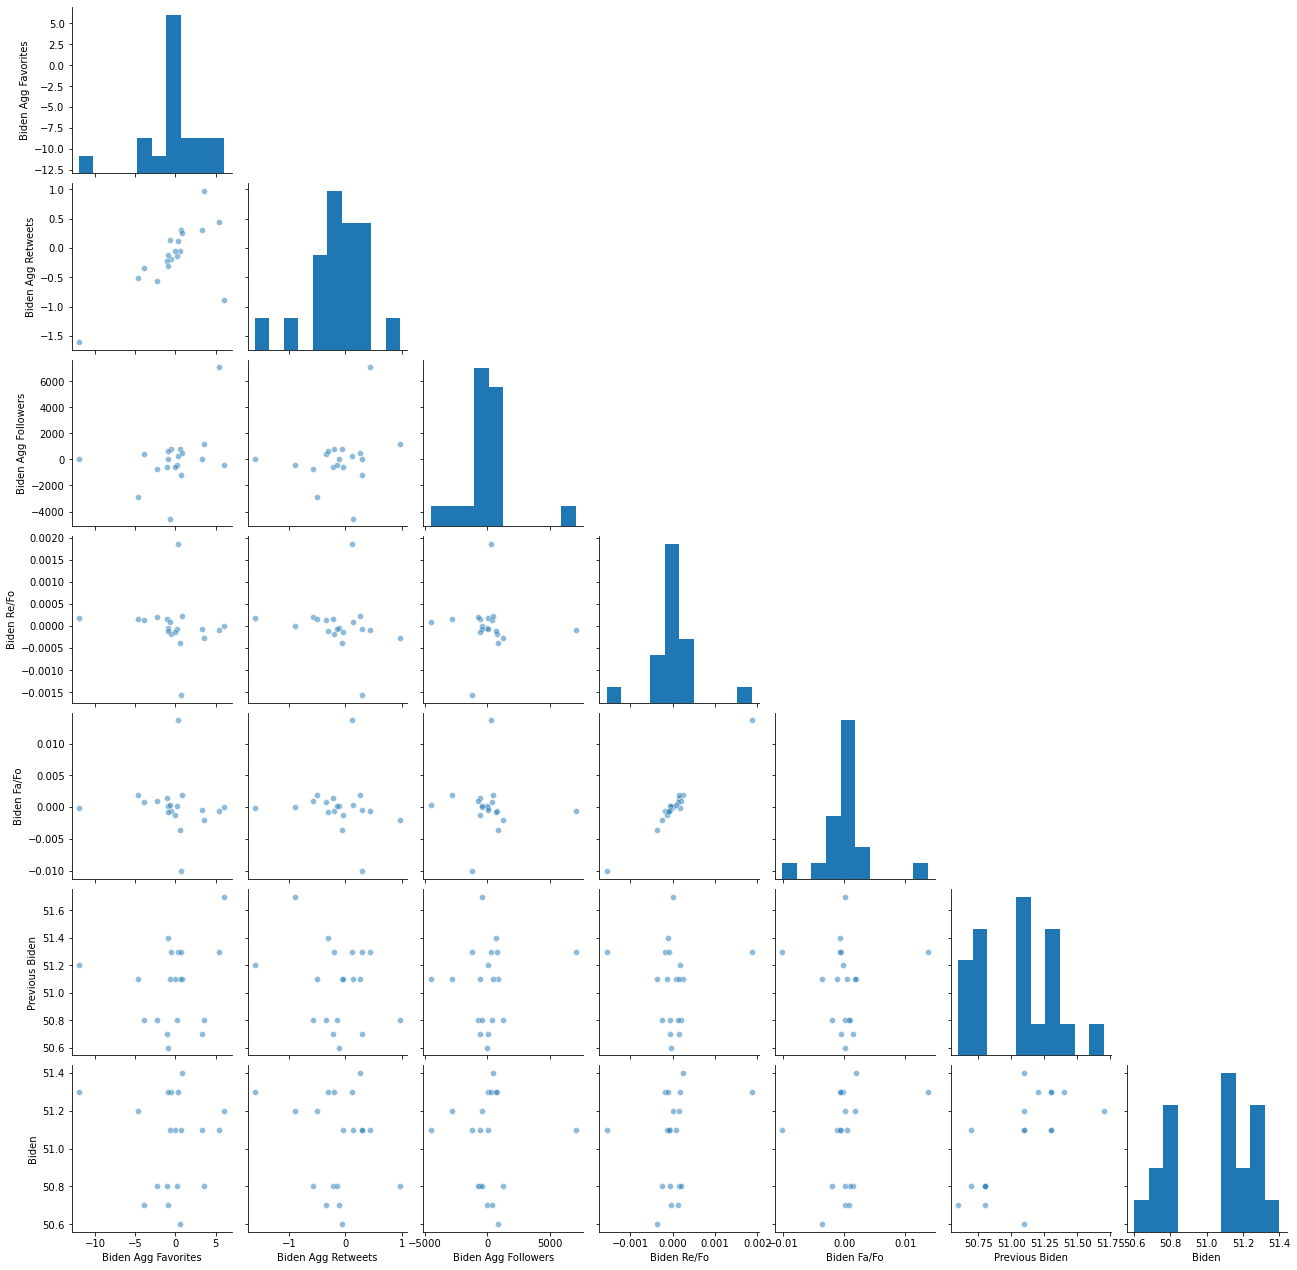

In [188]:
#EDA to see some of the relations in the data
fig = sns.pairplot(biden_agg,  plot_kws=dict(marker="o", alpha = 0.5))
for i, j in zip(*np.triu_indices_from(fig.axes, 1)):
    fig.axes[i, j].set_visible(False)
plt.show()

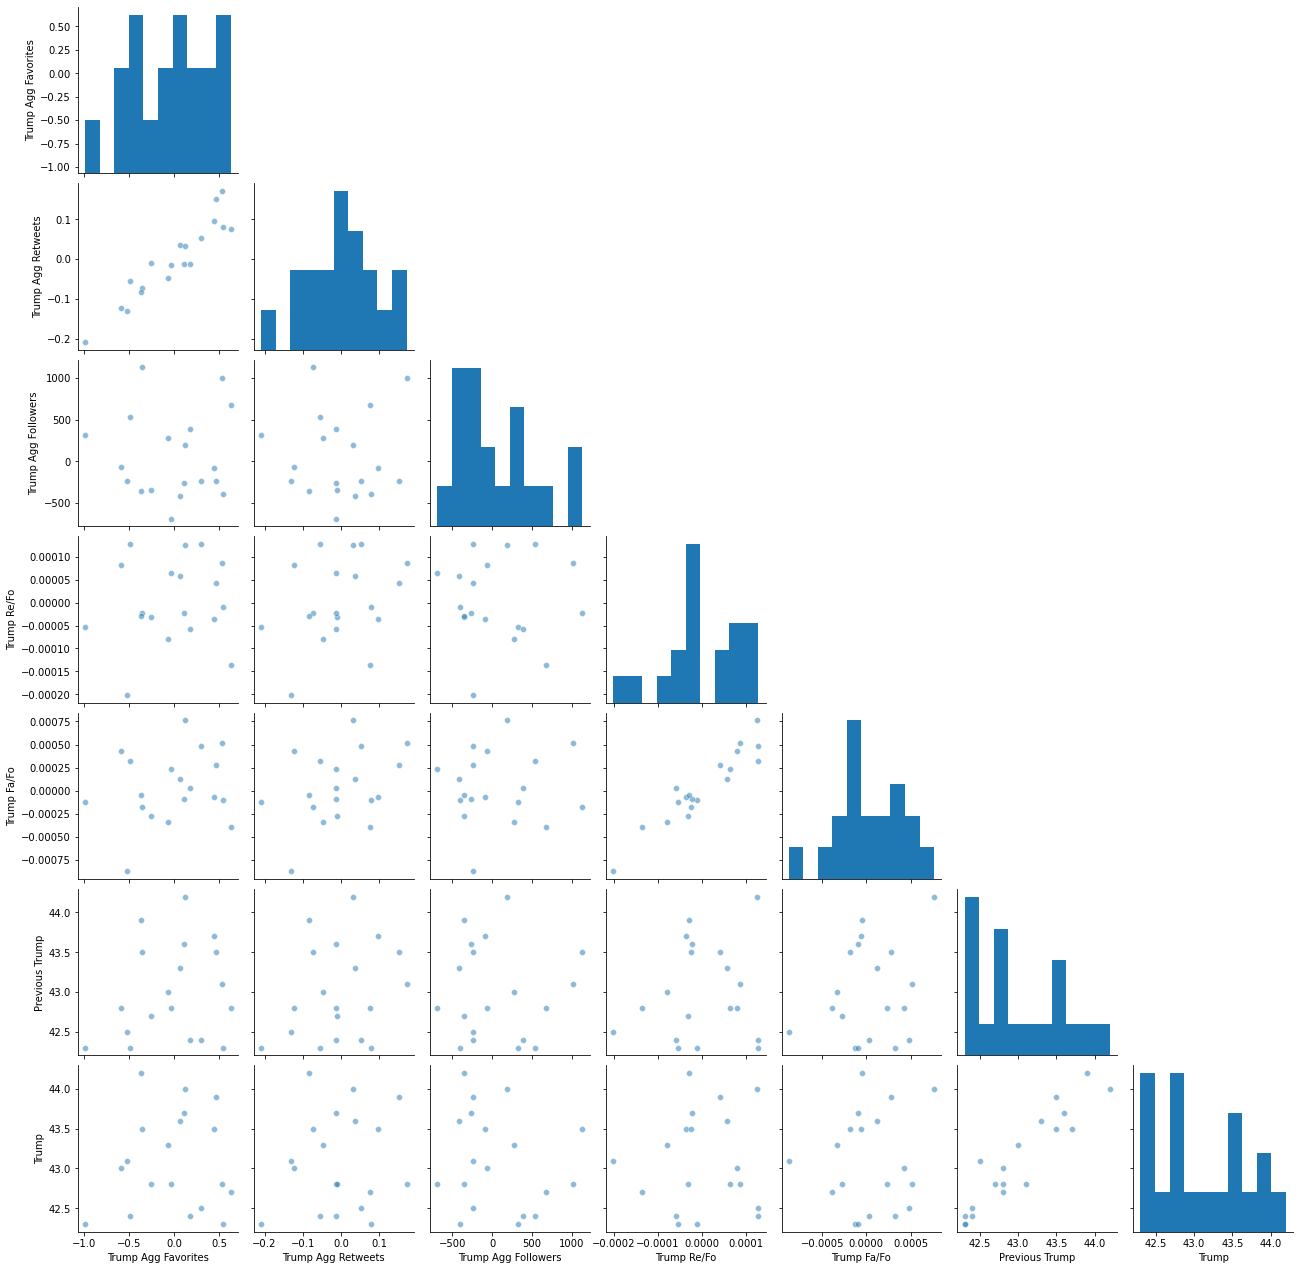

In [189]:
fig = sns.pairplot(trump_agg,  plot_kws=dict(marker="o", alpha = 0.5))
for i, j in zip(*np.triu_indices_from(fig.axes, 1)):
    fig.axes[i, j].set_visible(False)
plt.show()

## Modeling the Difference Between Canididates' Vote Share

In [232]:
# ~80%/20% training/test set split (15 days for training, 4 for evaluation)
X_train_b = biden_agg[:15].drop(['Biden'], axis = 1)
y_train_b = biden_agg[:15]['Biden']

X_test_b = biden_agg[15:].drop(['Biden'], axis = 1)
y_test_b = biden_agg[15:]['Biden']

X_train_t = trump_agg[:15].drop(['Trump'], axis = 1)
y_train_t = trump_agg[:15]['Trump']

X_test_t = trump_agg[15:].drop(['Trump'], axis = 1)
y_test_t = trump_agg[15:]['Trump']

In [233]:
#Method to output the MAE (mean average error) to find vote share and R^2
#R^2 is the correlation against preelectoral polls
import sklearn.metrics as metrics
def regression_results(b_true, b_pred, t_true, t_pred):
    biden_r2 = metrics.r2_score(b_true, b_pred)
    trump_r2 = metrics.r2_score(t_true, t_pred)
    print('R^2: ', round((biden_r2 + trump_r2)/2, 2))
    mae = round(abs(b_pred[-1][0] - 51.3) + abs(t_pred[-1][0] - 46.8), 2) / 2
    print('MAE: ', mae)

In [241]:
#Creating training and validation sets (~80/20 split)
X_t_b = X_train_b[:12].copy()
y_t_b = y_train_b[:12].copy()

X_v_b = X_train_b[12:].copy()
y_v_b = y_train_b[12:].copy()

X_t_t = X_train_t[:12].copy()
y_t_t = y_train_t[:12].copy()

X_v_t = X_train_t[12:].copy()
y_v_t = y_train_t[12:].copy()

In [242]:
#Figuring out which model to use
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

models = []
#Good for a few important features
models.append(('Lasso', (Lasso(), Lasso())))
models.append(('Elastic', (ElasticNet(), ElasticNet())))

#Good for predicting from all features
models.append(('Ridge Regression', (Ridge(), Ridge())))
models.append(('SVR Linear', (SVR(kernel='linear'), SVR(kernel='linear'))))

#Other useful methods
models.append(('SVR RBF', (SVR(kernel='rbf'), SVR(kernel='rbf'))))
models.append(('Random Forest', (RandomForestRegressor(), RandomForestRegressor())))

predictions = []
#Evaluating each model
for name, model in models:
    
    model_b = model[0]
    model_t = model[1]
    model_b.fit(X_t_b, y_t_b)
    model_t.fit(X_t_t, y_t_t)
    
    #Predicting the polling value day-by-day so it can be included in the model
    b_pred = []
    t_pred = []
    prev_poll_b = y_t_b[-1]
    prev_poll_t = y_t_t[-1]
    for day in X_v_b.index:
        X_v_b.loc[day:day+pd.Timedelta("1 hour"), 'Previous Biden'] = prev_poll_b
        prev_poll_b = model_b.predict(X_v_b.loc[day:day+pd.Timedelta("1 hour"), :])
        b_pred.append(prev_poll_b)
    
        X_v_t.loc[day:day+pd.Timedelta("1 hour"), 'Previous Trump'] = prev_poll_t
        prev_poll_t = model_t.predict(X_v_t.loc[day:day+pd.Timedelta("1 hour"), :])
        t_pred.append(prev_poll_t)
        
    predictions.append((b_pred, t_pred))
    print('%s:' % (name))
    regression_results(y_v_b, b_pred, y_v_t, t_pred);

Lasso:
R^2:  -60.08
MAE:  2.23
Elastic:
R^2:  -59.98
MAE:  2.23
Ridge Regression:
R^2:  -38.04
MAE:  2.22
SVR Linear:
R^2:  -13.44
MAE:  2.025
SVR RBF:
R^2:  -53.85
MAE:  2.135
Random Forest:
R^2:  -48.37
MAE:  2.255


In [244]:
model_b = SVR(kernel='linear')
model_t = SVR(kernel='linear')
model_b.fit(X_train_b, y_train_b)
model_t.fit(X_train_t, y_train_t)
    
#Predicting the polling value day-by-day so it can be included in the model
b_pred = []
t_pred = []
prev_poll_b = y_train_b[-1]
prev_poll_t = y_train_t[-1]
for day in X_test_b.index:
    X_test_b.loc[day:day+pd.Timedelta("1 hour"), 'Previous Biden'] = prev_poll_b
    prev_poll_b = model_b.predict(X_test_b.loc[day:day+pd.Timedelta("1 hour"), :])
    b_pred.append(prev_poll_b)
    
    X_test_t.loc[day:day+pd.Timedelta("1 hour"), 'Previous Trump'] = prev_poll_t
    prev_poll_t = model_t.predict(X_test_t.loc[day:day+pd.Timedelta("1 hour"), :])
    t_pred.append(prev_poll_t)
        
print('Final Model Results:')
regression_results(y_test_b, b_pred, y_test_t, t_pred)
print('Biden Vote Share: Predicted-', round(b_pred[-1][0], 1), 'Actual- 51.3')
print('Trump Vote Share: Predicted-', round(t_pred[-1][0], 1), 'Actual- 46.8')
print('Polling MAE: ', round(abs(y_test_b[-1] - 51.3) + abs(y_test_t[-1] - 46.8) / 2, 2))

Final Model Results:
R^2:  -3.13
MAE:  1.85
Biden Vote Share: Predicted- 50.9 Actual- 51.3
Trump Vote Share: Predicted- 43.5 Actual- 46.8
Polling MAE:  1.5


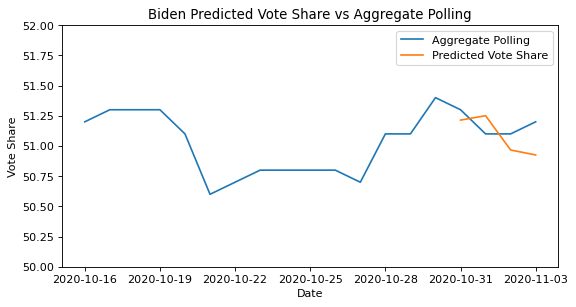

In [282]:
from matplotlib.pyplot import figure
figure(figsize=(8, 4), dpi=80)
plt.plot(biden_agg['Biden'], label='Aggregate Polling')
plt.plot(y_test_b.index, b_pred, label='Predicted Vote Share')
plt.xlabel('Date')
plt.ylabel('Vote Share')
xticks = ['2020/10/16', '2020/10/19', '2020/10/22', '2020/10/25', '2020/10/28', '2020/10/31', '2020/11/03']
plt.xticks(pd.to_datetime(xticks))
plt.ylim([50, 52])
plt.title('Biden Predicted Vote Share vs Aggregate Polling')
plt.legend();

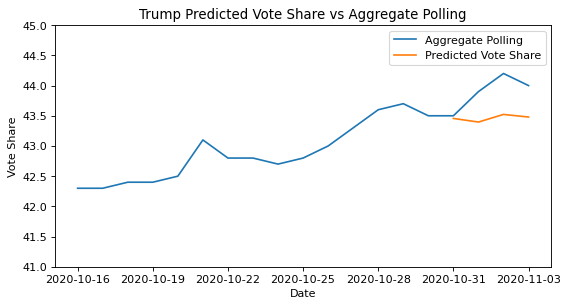

In [287]:
figure(figsize=(8, 4), dpi=80)
plt.plot(trump_agg['Trump'], label='Aggregate Polling')
plt.plot(y_test_t.index, t_pred, label='Predicted Vote Share')
plt.xlabel('Date')
plt.ylabel('Vote Share')
xticks = ['2020/10/16', '2020/10/19', '2020/10/22', '2020/10/25', '2020/10/28', '2020/10/31', '2020/11/03']
plt.xticks(pd.to_datetime(xticks))
plt.ylim([41, 45])
plt.title('Trump Predicted Vote Share vs Aggregate Polling')
plt.legend();